# **🤖 ML Modeling**

---

## 📥 Imports

In [143]:
# Data
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Misc
import warnings

In [144]:
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

## 🎨 Styling

In [145]:
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FF8FB8'

text_darker = '#7a8493'
text = '#a0a9b6'
background = '#f9fafc'

# Qualitative colormap
palette = [blue, red, amber, mint, purple, pink]

In [146]:
params = {
    'figure.figsize': (9, 6), 
    'figure.dpi': 150,
    'figure.facecolor': background,
    
    'axes.facecolor': background,
    'axes.edgecolor': text, 
    'axes.labelcolor': text,
    'axes.titlecolor': text_darker,
    'text.color': text, 
    'xtick.color': text, 
    'ytick.color': text,
    
    'font.size': 16, 
    'axes.titlesize': 16,    
    'axes.labelsize': 12,
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    
    'axes.spines.right': False, 
    'axes.spines.top': False
}

sns.set(context='notebook', style='white', palette=palette, rc=params)

## 🎒  Data Loading

In [147]:
df = pd.read_csv("../data/processed/demand_products.csv")
df_test = pd.read_csv("../data/processed/demand_products_test.csv")

## 🌿 Data preparation

### Feature Engineering 
For this part, we will:
- Create lagged features for past demand to capture temporal dependencies.
- Generate rolling statistics like the mean and standard deviation of past demand.
- Add day-of-week, month, and year as additional features.

---

The first step is to create lagged features based on past demand. This helps to capture the temporal dependency in the data. For example, the demand for a product today might be influenced by its demand yesterday or the day before.

We'll create lagged features for the past 1, 7, and 30 days to capture daily, weekly, and monthly patterns.

In [148]:
df = df.sort_values(['product_id', 'date'])

lag_days = [1, 7, 30]
lagged_df = pd.DataFrame()

# loop through each unique product to generate lagged features
for product in df['product_id'].unique():
    product_df = df[df['product_id'] == product].copy()
    for lag in lag_days:
        product_df[f'demand_lag_{lag}'] = product_df['demand'].shift(lag)
    lagged_df = pd.concat([lagged_df, product_df])

lagged_df = lagged_df.dropna().reset_index(drop=True)
lagged_df.head(3)

,date,product_id,demand,category,subcategory,size,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30
0,2020-02-08,1,91,bebidas,agua,mediano,False,True,False,76.000,105.000,110.000
1,2020-02-09,1,80,bebidas,agua,mediano,False,True,False,91.000,137.000,140.000
2,2020-02-10,1,63,bebidas,agua,mediano,False,True,False,80.000,115.000,121.000


Now let's generate rolling statistics can help capture the trends and variability in the demand over a period of time. For example, the rolling mean over the past 7 days can give us an idea of the average demand for that week.

In [149]:
rolling_stats_df = pd.DataFrame()
rolling_windows = [7, 30]

for product in lagged_df['product_id'].unique():
    product_df = lagged_df[lagged_df['product_id'] == product].copy()
    
    for window in rolling_windows:
        product_df[f'rolling_mean_{window}'] = product_df['demand'].rolling(window=window, closed= "left").mean()
        product_df[f'rolling_std_{window}'] = product_df['demand'].rolling(window=window, closed= "left").std()
    
    rolling_stats_df = pd.concat([rolling_stats_df, product_df])

rolling_stats_df = rolling_stats_df.dropna().reset_index(drop=True)
rolling_stats_df.head()

,date,product_id,demand,category,subcategory,size,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
0,2020-03-10,1,62,bebidas,agua,mediano,False,True,False,53.000,65.000,91.000,69.429,10.502,78.733,14.676
1,2020-03-11,1,63,bebidas,agua,mediano,False,True,False,62.000,74.000,80.000,69.000,10.770,77.767,14.794
2,2020-03-12,1,74,bebidas,agua,mediano,False,True,False,63.000,78.000,63.000,67.429,10.722,77.200,15.030
3,2020-03-13,1,69,bebidas,agua,mediano,False,True,False,74.000,67.000,75.000,66.857,10.156,77.567,14.804
4,2020-03-14,1,74,bebidas,agua,mediano,False,True,False,69.000,64.000,77.000,67.143,10.189,77.367,14.880


Finally, we add time-based features which can help the model understand seasonal patterns, trends, or specific behaviors related to different times of the year.

In [150]:
rolling_stats_df['date'] = pd.to_datetime(rolling_stats_df['date'])

rolling_stats_df['day_of_week'] = rolling_stats_df['date'].dt.dayofweek
rolling_stats_df['month'] = rolling_stats_df['date'].dt.month
rolling_stats_df['year'] = rolling_stats_df['date'].dt.year

rolling_stats_df.head()

,date,product_id,demand,category,subcategory,size,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,month,year
0,2020-03-10,1,62,bebidas,agua,mediano,False,True,False,53.000,65.000,91.000,69.429,10.502,78.733,14.676,1,3,2020
1,2020-03-11,1,63,bebidas,agua,mediano,False,True,False,62.000,74.000,80.000,69.000,10.770,77.767,14.794,2,3,2020
2,2020-03-12,1,74,bebidas,agua,mediano,False,True,False,63.000,78.000,63.000,67.429,10.722,77.200,15.030,3,3,2020
3,2020-03-13,1,69,bebidas,agua,mediano,False,True,False,74.000,67.000,75.000,66.857,10.156,77.567,14.804,4,3,2020
4,2020-03-14,1,74,bebidas,agua,mediano,False,True,False,69.000,64.000,77.000,67.143,10.189,77.367,14.880,5,3,2020


Let's apply the same steps to test

In [151]:
df_test['date'] = pd.to_datetime(df_test['date'])

df_test['day_of_week'] = df_test['date'].dt.dayofweek  # Monday=0, Sunday=6
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year

In [152]:
df_test.head()

,date,product_id,category,subcategory,size,is_premium,is_exclusive,is_seasonal,day_of_week,month,year
0,2022-12-01,1,bebidas,agua,mediano,False,True,False,3,12,2022
1,2022-12-01,2,jabones,antibacterial,pequeño,False,False,False,3,12,2022
2,2022-12-01,3,bebidas,gaseosa,pequeño,False,True,False,3,12,2022
3,2022-12-01,4,congelados,vegetales,pequeño,False,True,True,3,12,2022
4,2022-12-01,5,shampoos,acondicionador,pequeño,False,True,False,3,12,2022


### Categorical Encoding

Use one-hot encoding or target encoding for the "category," "subcategory," and "size" columns.

In [153]:
cat_columns = ['category', 'subcategory', 'size']
one_hot_train_df = pd.get_dummies(
    rolling_stats_df, 
    columns=cat_columns, 
    drop_first=True
)

one_hot_train_df.head()

,date,product_id,demand,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,month,year,category_bebidas,category_carnes_y_aves,category_cereales_y_productos_secos,category_congelados,category_frutas_y_verduras,category_jabones,category_panaderia_y_panificados,category_productos_enlatados_y_alimentos_envasados,category_productos_lacteos,category_shampoos,subcategory_agua,subcategory_antibacterial,subcategory_arroz,subcategory_cerdo,subcategory_cerveza internacional,subcategory_cerveza nacional,subcategory_crema,subcategory_cuidado personal,subcategory_enlatadas,subcategory_frescas,subcategory_frutos secos,subcategory_gaseosa,subcategory_helados,subcategory_hidratante,subcategory_indefinido,subcategory_integral,subcategory_leche,subcategory_legumbres,subcategory_licor nacional,subcategory_limpieza general,subcategory_otros,subcategory_pasta,subcategory_pavo,subcategory_pollo,subcategory_queso,subcategory_res,subcategory_vegetales,subcategory_vinos,subcategory_yogur,size_mediano,size_pequeño
0,2020-03-10,1,62,False,True,False,53.000,65.000,91.000,69.429,10.502,78.733,14.676,1,3,2020,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,2020-03-11,1,63,False,True,False,62.000,74.000,80.000,69.000,10.770,77.767,14.794,2,3,2020,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,2020-03-12,1,74,False,True,False,63.000,78.000,63.000,67.429,10.722,77.200,15.030,3,3,2020,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,2020-03-13,1,69,False,True,False,74.000,67.000,75.000,66.857,10.156,77.567,14.804,4,3,2020,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,2020-03-14,1,74,False,True,False,69.000,64.000,77.000,67.143,10.189,77.367,14.880,5,3,2020,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


Let's apply the same steps to test

In [154]:
one_hot_test_df = pd.get_dummies(df_test, columns=cat_columns, drop_first=True)

# make sure the test dataset has the same columns as train
missing_cols = set(one_hot_train_df.columns) - set(one_hot_test_df.columns) - {'demand'}
for col in missing_cols:
    one_hot_test_df[col] = 0

one_hot_test_df = one_hot_test_df[one_hot_train_df.drop(columns=['demand']).columns]
one_hot_test_df.head()

,date,product_id,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,month,year,category_bebidas,category_carnes_y_aves,category_cereales_y_productos_secos,category_congelados,category_frutas_y_verduras,category_jabones,category_panaderia_y_panificados,category_productos_enlatados_y_alimentos_envasados,category_productos_lacteos,category_shampoos,subcategory_agua,subcategory_antibacterial,subcategory_arroz,subcategory_cerdo,subcategory_cerveza internacional,subcategory_cerveza nacional,subcategory_crema,subcategory_cuidado personal,subcategory_enlatadas,subcategory_frescas,subcategory_frutos secos,subcategory_gaseosa,subcategory_helados,subcategory_hidratante,subcategory_indefinido,subcategory_integral,subcategory_leche,subcategory_legumbres,subcategory_licor nacional,subcategory_limpieza general,subcategory_otros,subcategory_pasta,subcategory_pavo,subcategory_pollo,subcategory_queso,subcategory_res,subcategory_vegetales,subcategory_vinos,subcategory_yogur,size_mediano,size_pequeño
0,2022-12-01,1,False,True,False,0,0,0,0,0,0,0,3,12,2022,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,2022-12-01,2,False,False,False,0,0,0,0,0,0,0,3,12,2022,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,2022-12-01,3,False,True,False,0,0,0,0,0,0,0,3,12,2022,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,2022-12-01,4,False,True,True,0,0,0,0,0,0,0,3,12,2022,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4,2022-12-01,5,False,True,False,0,0,0,0,0,0,0,3,12,2022,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


### Boolean Feature Transformation

Convert boolean columns ("is_premium," "is_exclusive," "is_seasonal") to integers (0 or 1).

In [155]:
bool_cols = one_hot_train_df.select_dtypes(bool).columns
one_hot_train_df[bool_cols] = one_hot_train_df[bool_cols].astype(int)
one_hot_test_df[bool_cols] = one_hot_test_df[bool_cols].astype(int)

In [156]:
one_hot_train_df.head()

,date,product_id,demand,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,month,year,category_bebidas,category_carnes_y_aves,category_cereales_y_productos_secos,category_congelados,category_frutas_y_verduras,category_jabones,category_panaderia_y_panificados,category_productos_enlatados_y_alimentos_envasados,category_productos_lacteos,category_shampoos,subcategory_agua,subcategory_antibacterial,subcategory_arroz,subcategory_cerdo,subcategory_cerveza internacional,subcategory_cerveza nacional,subcategory_crema,subcategory_cuidado personal,subcategory_enlatadas,subcategory_frescas,subcategory_frutos secos,subcategory_gaseosa,subcategory_helados,subcategory_hidratante,subcategory_indefinido,subcategory_integral,subcategory_leche,subcategory_legumbres,subcategory_licor nacional,subcategory_limpieza general,subcategory_otros,subcategory_pasta,subcategory_pavo,subcategory_pollo,subcategory_queso,subcategory_res,subcategory_vegetales,subcategory_vinos,subcategory_yogur,size_mediano,size_pequeño
0,2020-03-10,1,62,0,1,0,53.000,65.000,91.000,69.429,10.502,78.733,14.676,1,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2020-03-11,1,63,0,1,0,62.000,74.000,80.000,69.000,10.770,77.767,14.794,2,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2020-03-12,1,74,0,1,0,63.000,78.000,63.000,67.429,10.722,77.200,15.030,3,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2020-03-13,1,69,0,1,0,74.000,67.000,75.000,66.857,10.156,77.567,14.804,4,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2020-03-14,1,74,0,1,0,69.000,64.000,77.000,67.143,10.189,77.367,14.880,5,3,2020,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Splitting Data
Keep a portion of the most recent data for validation. 

In [157]:
one_hot_train_df['date'] = pd.to_datetime(one_hot_train_df['date'])
cutoff_date = one_hot_train_df['date'].max() - pd.Timedelta(days=30)

train_set = one_hot_train_df[one_hot_train_df['date'] <= cutoff_date]
validation_set = one_hot_train_df[one_hot_train_df['date'] > cutoff_date]

train_set.shape, validation_set.shape

((114529, 57), (3831, 57))

In [158]:
train_set.to_csv("../data/final/train.csv", index=False)
validation_set.to_csv("../data/final/validation.csv", index=False)

## 🦾 Training

To model our data we will use a linear regression as a baseline, and then proceed with a more robust XGBoost.

In [159]:
X_train = train_set.drop(['demand', 'date', 'product_id'], axis=1)
y_train = train_set['demand']

X_val = validation_set.drop(['demand', 'date', 'product_id'], axis=1)
y_val = validation_set['demand']

In [160]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_val_pred = baseline_model.predict(X_val)

In [161]:
# Calculate the RMSE on the validation set
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'RSME: {baseline_rmse:.2f}')

RSME: 42.41


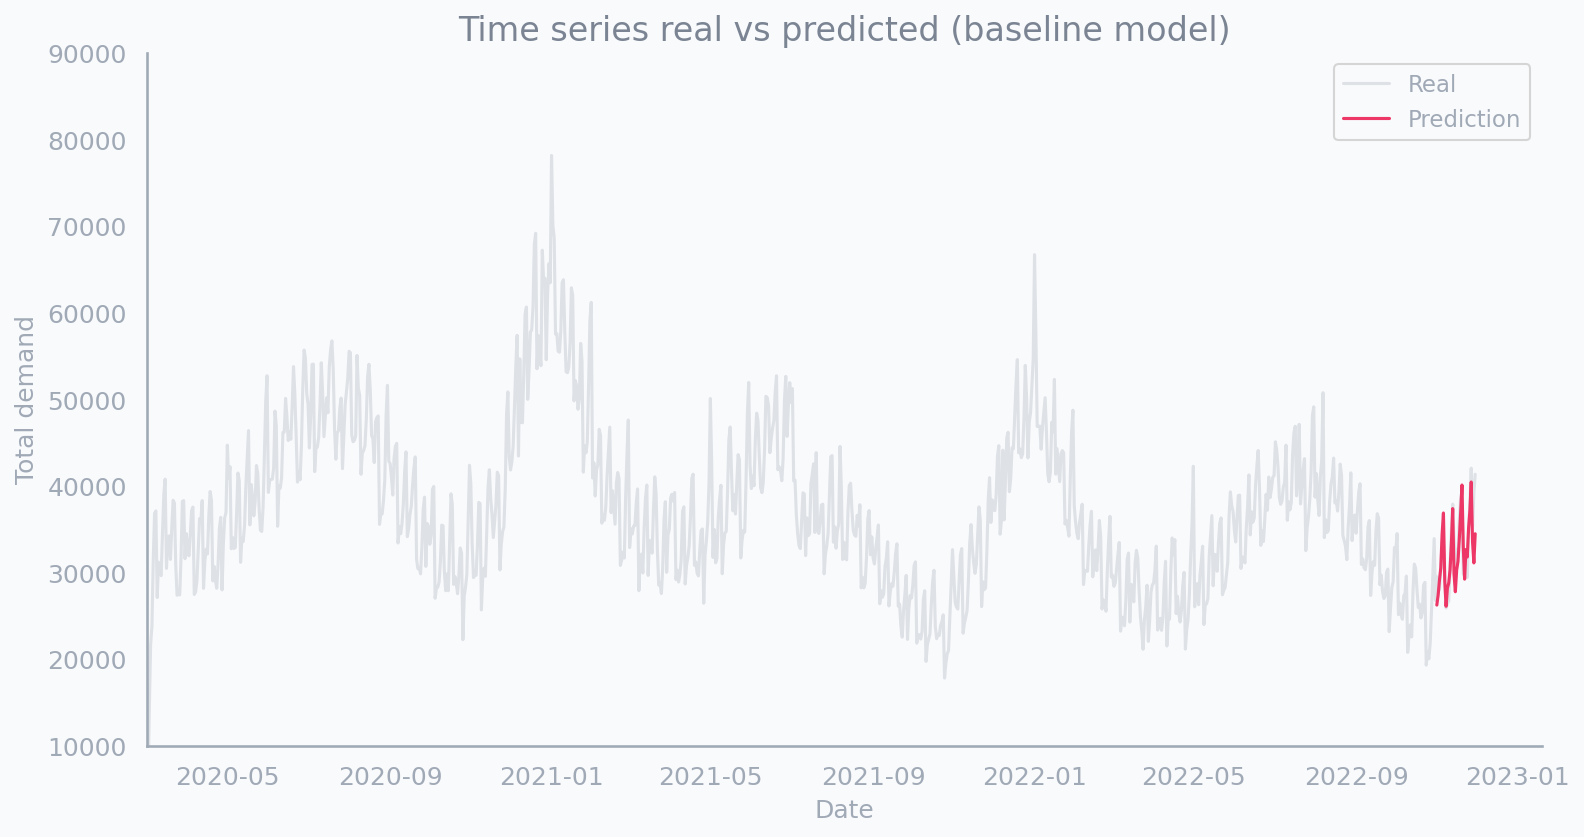

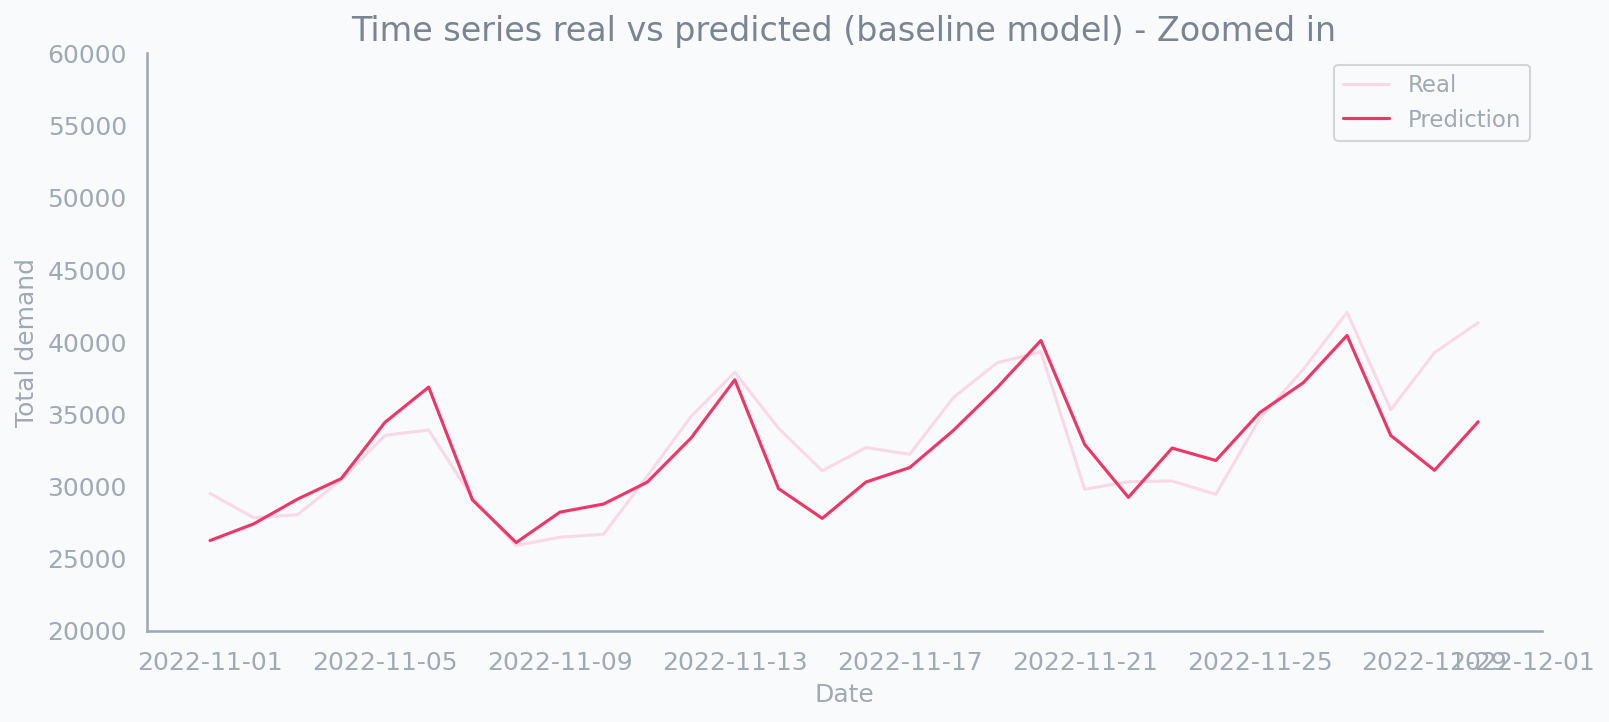

In [162]:
demand_real = one_hot_train_df.groupby("date")['demand'].sum().to_frame()

demand_pred = pd.DataFrame(
    {'demand': y_val.values, 'demand_pred': y_val_pred},
    index=validation_set['date']
)
demand_pred = demand_pred.resample('D').sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=demand_real, x="date", y="demand", color=text, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=red, label='Prediction')
plt.title("Time series real vs predicted (baseline model)")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(10_000, 90_000)
plt.xlim(pd.Timestamp('2020-03-01'))
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=demand_pred, x="date", y="demand", color=pink, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=red, label='Prediction')
plt.title("Time series real vs predicted (baseline model) - Zoomed in")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(20_000, 60_000)
plt.show()

### XGBoost

In [24]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 10,],
    'n_estimators': [50, 100]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv=5,
                           verbose=0)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [7, 10, 15],
                         'n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error')

In [31]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_results_df = grid_results_df.sort_values('rank_test_score').head(6)
grid_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,3.22,0.47,0.06,0.01,0.10,10,100,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",-29.54,-38.53,-27.58,-32.31,-32.69,-32.13,3.71,1
7,1.43,0.21,0.04,0.00,0.10,7,100,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",-30.24,-38.77,-29.32,-33.38,-34.18,-33.18,3.34,2
8,1.63,0.10,0.04,0.00,0.10,10,50,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",-30.26,-39.79,-28.89,-33.37,-33.93,-33.25,3.77,3
11,21.92,2.46,0.18,0.04,0.10,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",-30.88,-40.42,-29.43,-33.62,-34.14,-33.70,3.78,4
10,11.14,1.02,0.10,0.02,0.10,15,50,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",-31.13,-40.80,-29.81,-34.00,-34.55,-34.06,3.80,5
6,1.48,1.10,0.03,0.01,0.10,7,50,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",-31.47,-40.93,-30.95,-35.22,-36.88,-35.09,3.68,6


In [32]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [163]:
best_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

xgb_model_best = xgb.XGBRegressor(objective='reg:squarederror', 
                                  eval_metric='rmse', **best_params)

In [164]:
xgb_model_best.fit(X_train, y_train)
y_val_pred_xg = xgb_model_best.predict(X_val)

In [165]:
# Calculate the RMSE on the validation set
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xg))
print(f'RSME: {baseline_rmse:.2f}')

RSME: 30.75


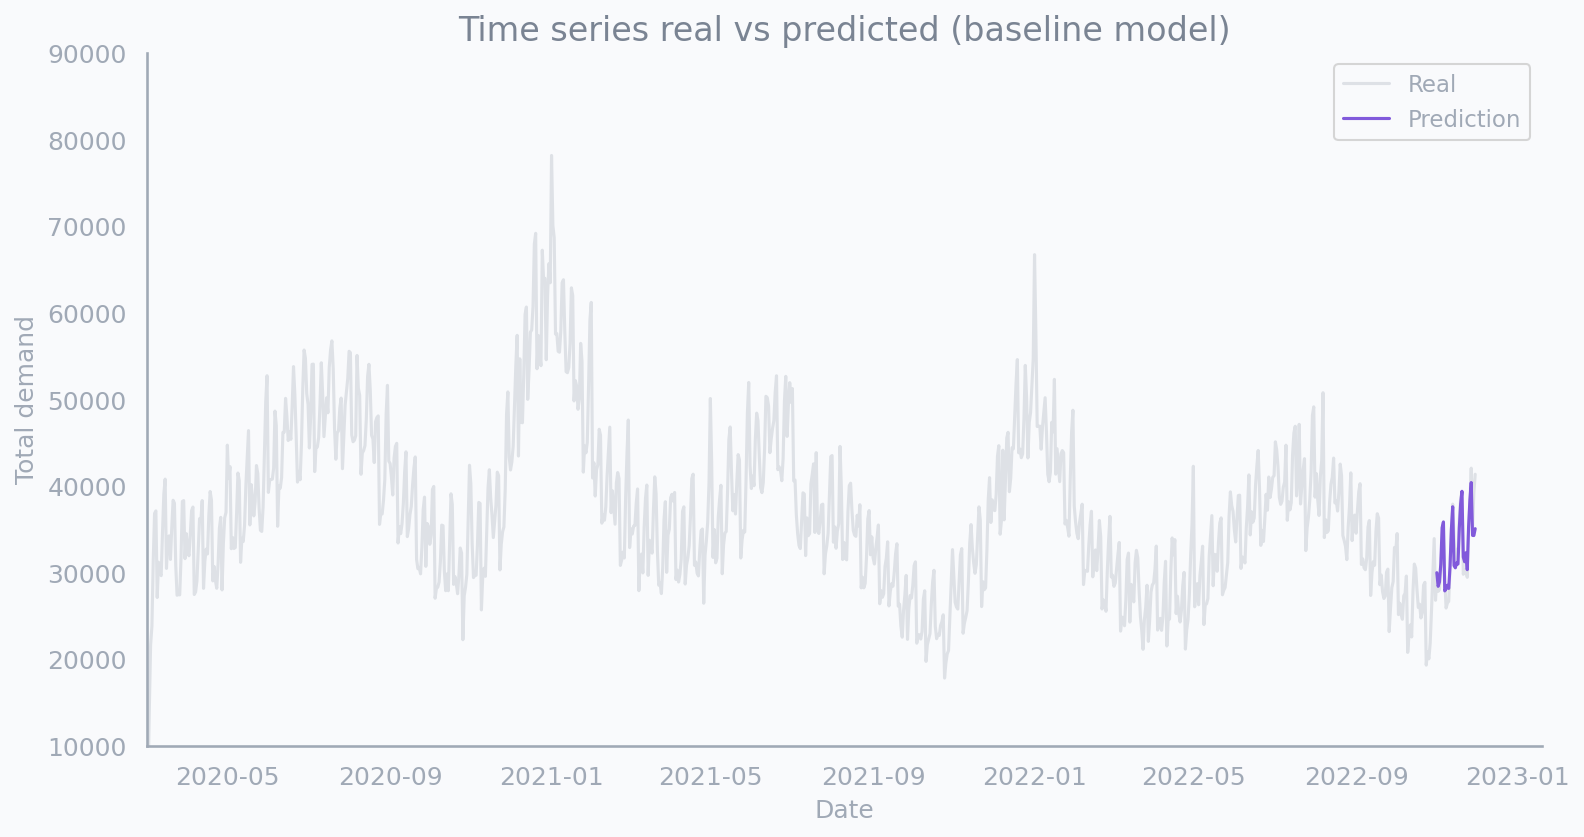

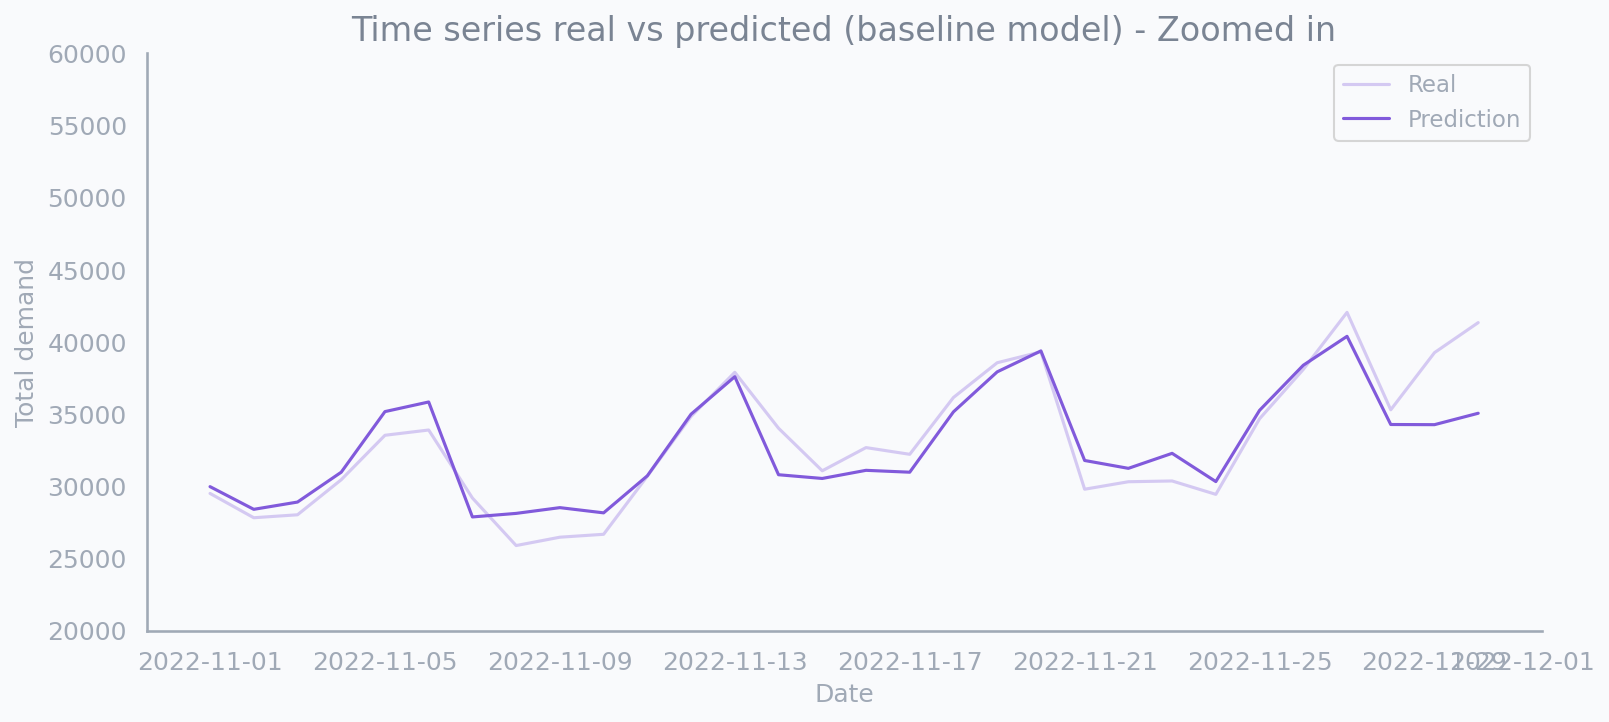

In [166]:
demand_pred = pd.DataFrame(
    {'demand': y_val.values, 'demand_pred': y_val_pred_xg},
    index=validation_set['date']
)
demand_pred = demand_pred.resample('D').sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=demand_real, x="date", y="demand", color=text, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=purple, label='Prediction')
plt.title("Time series real vs predicted (baseline model)")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(10_000, 90_000)
plt.xlim(pd.Timestamp('2020-03-01'))
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=demand_pred, x="date", y="demand", color=purple, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=purple, label='Prediction')
plt.title("Time series real vs predicted (baseline model) - Zoomed in")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(20_000, 60_000)
plt.show()

In [178]:
train_set_xg = pd.read_csv("../data/final/train.csv")
validation_set_xg = pd.read_csv("../data/final/validation.csv")

train_set_xg['demand_pred'] = train_set_xg['demand']
validation_set_xg['demand_pred'] = np.nan

after_cols = [
    col for col in validation_set_xg.columns 
    if 'lag' in col or 'rolling' in col
]
validation_set_xg[after_cols] = np.nan

set_xg = pd.concat([train_set_xg, validation_set_xg], ignore_index=True)
set_xg = set_xg.sort_values(['product_id', 'date']).reset_index(drop=True)

In [199]:
# one step prediction loop
i = 0

lag_days = [1, 7, 30]
rolling_windows = [7, 30]

val_dates = validation_set_xg['date'].unique()
val_dates.sort()
 
for date in val_dates:
    print(i, date, sep=", ", end=" ")
    
    # generate lagged features and update the dataset
    for product in set_xg['product_id'].unique():
        mask = (set_xg['product_id'] == product) & (set_xg['date'] <= date)
        product_df = set_xg.loc[mask].copy()
        
        mask_day = (set_xg.product_id == product) & (set_xg.date == date)
        for lag in lag_days:
            lagged_demand = product_df['demand_pred'].shift(lag).values[-1]
            set_xg.loc[mask_day, f'demand_lag_{lag}'] = lagged_demand
        
        mask = (set_xg['product_id'] == product) & (set_xg['date'] <= date)
        product_df = set_xg.loc[mask].copy()
        for window in rolling_windows:
            rolling_mean = product_df['demand_pred'].rolling(window=window, closed= "left").mean().values[-1]
            rolling_std = product_df['demand_pred'].rolling(window=window, closed= "left").std().values[-1]
            set_xg.loc[mask_day, f'rolling_mean_{window}'] = rolling_mean
            set_xg.loc[mask_day, f'rolling_std_{window}'] = rolling_std
            
    # prepare features and target for this specific day
    val_day_data = set_xg[set_xg['date'] == date]
    
    # split input and target
    drop_cols = ['demand', 'date', 'product_id', 'demand_pred']
    X_val_day = val_day_data.drop(drop_cols, axis=1)
    y_val_day = val_day_data['demand']
    
    # predict and store the prediction
    y_val_pred_day = xgb_model_best.predict(X_val_day)
    set_xg.loc[set_xg['date'] == date, 'demand_pred'] = y_val_pred_day
    
    day_rmse = np.sqrt(mean_squared_error(y_val_day, y_val_pred_day))
    print(f'-> RSME: {day_rmse:.2f}')

    i += 1

0, 2022-11-01 -> RSME: 34.00
1, 2022-11-02 -> RSME: 30.10
2, 2022-11-03 -> RSME: 30.43
3, 2022-11-04 -> RSME: 34.88
4, 2022-11-05 -> RSME: 44.87
5, 2022-11-06 -> RSME: 51.10
6, 2022-11-07 -> RSME: 52.43
7, 2022-11-08 -> RSME: 46.69
8, 2022-11-09 -> RSME: 46.58
9, 2022-11-10 -> RSME: 46.75
10, 2022-11-11 -> RSME: 40.99
11, 2022-11-12 -> RSME: 40.08
12, 2022-11-13 -> RSME: 34.22
13, 2022-11-14 -> RSME: 52.14
14, 2022-11-15 -> RSME: 28.80
15, 2022-11-16 -> RSME: 25.13
16, 2022-11-17 -> RSME: 29.73
17, 2022-11-18 -> RSME: 28.50
18, 2022-11-19 -> RSME: 34.03
19, 2022-11-20 -> RSME: 34.02
20, 2022-11-21 -> RSME: 35.51
21, 2022-11-22 -> RSME: 40.38
22, 2022-11-23 -> RSME: 46.92
23, 2022-11-24 -> RSME: 49.24
24, 2022-11-25 -> RSME: 46.75
25, 2022-11-26 -> RSME: 42.54
26, 2022-11-27 -> RSME: 43.42
27, 2022-11-28 -> RSME: 39.16
28, 2022-11-29 -> RSME: 55.17
29, 2022-11-30 -> RSME: 72.56


In [200]:
date_mask = set_xg.date.isin(val_dates)

y_val = set_xg.loc[date_mask].demand
y_val_pred_xg_steps = set_xg.loc[date_mask].demand_pred

xg_step_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xg_steps))
print(f'RSME: {xg_step_rmse:.2f}')

RSME: 42.45


In [201]:
demand_pred = pd.DataFrame(
    {'demand': y_val.values, 'demand_pred': y_val_pred_xg_steps.values},
    index=pd.to_datetime(set_xg.loc[date_mask].date)
)
demand_pred = demand_pred.resample('D').sum().reset_index()
demand_pred

,date,demand,demand_pred
0,2022-11-01,29520,29989.817
1,2022-11-02,27836,28787.759
2,2022-11-03,28041,29440.197
3,2022-11-04,30469,32295.102
4,2022-11-05,33548,36326.353
5,2022-11-06,33913,37644.513
6,2022-11-07,29202,30565.675
7,2022-11-08,25910,29644.061
8,2022-11-09,26488,30841.018
9,2022-11-10,26690,31078.111


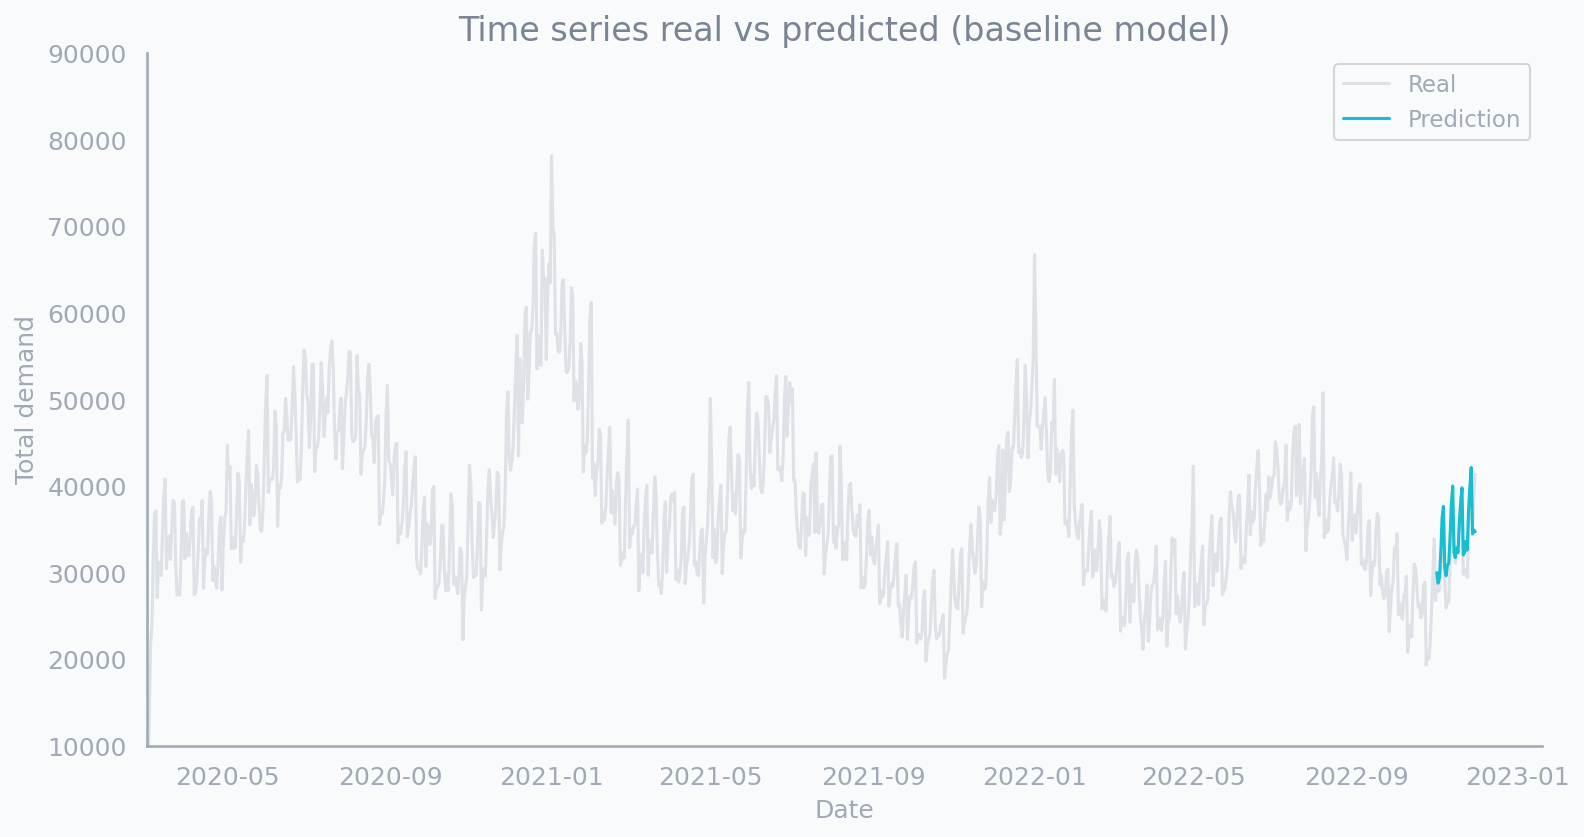

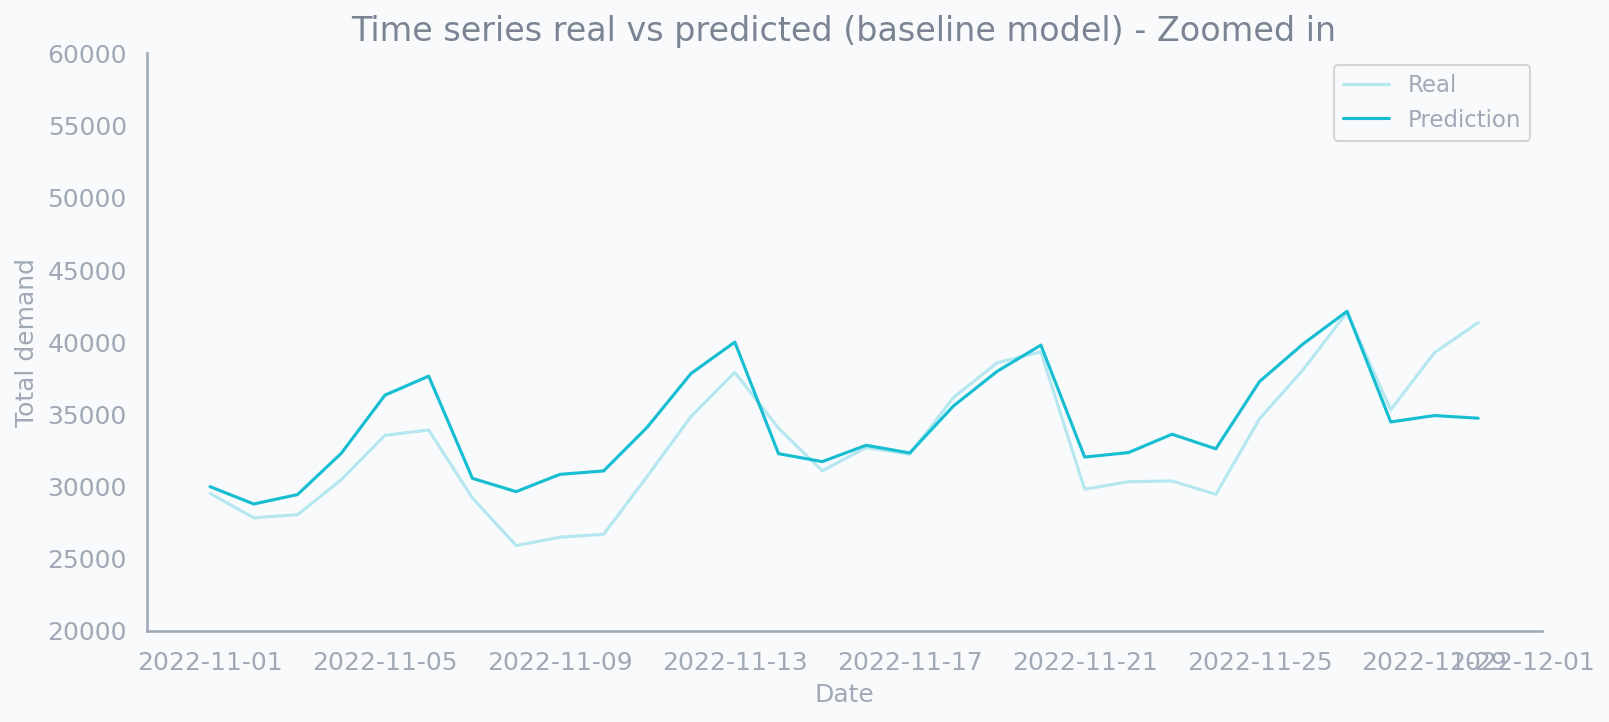

In [202]:
demand_pred = pd.DataFrame(
    {'demand': y_val.values, 'demand_pred': y_val_pred_xg_steps.values},
    index=pd.to_datetime(set_xg.loc[date_mask].date)
)
demand_pred = demand_pred.resample('D').sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=demand_real, x="date", y="demand", color=text, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=mint, label='Prediction')
plt.title("Time series real vs predicted (baseline model)")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(10_000, 90_000)
plt.xlim(pd.Timestamp('2020-03-01'))
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=demand_pred, x="date", y="demand", color=mint, label='Real', alpha=0.3)
sns.lineplot(data=demand_pred, x="date", y="demand_pred", color=mint, label='Prediction')
plt.title("Time series real vs predicted (baseline model) - Zoomed in")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(20_000, 60_000)
plt.show()

## ⏭️ Results and next steps

In [206]:
after_cols = [
    col for col in validation_set_xg.columns 
    if 'lag' in col or 'rolling' in col
]
one_hot_test_df[after_cols] = np.nan

one_hot_test_df.head()

,date,product_id,is_premium,is_exclusive,is_seasonal,demand_lag_1,demand_lag_7,demand_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,month,year,category_bebidas,category_carnes_y_aves,category_cereales_y_productos_secos,category_congelados,category_frutas_y_verduras,category_jabones,category_panaderia_y_panificados,category_productos_enlatados_y_alimentos_envasados,category_productos_lacteos,category_shampoos,subcategory_agua,subcategory_antibacterial,subcategory_arroz,subcategory_cerdo,subcategory_cerveza internacional,subcategory_cerveza nacional,subcategory_crema,subcategory_cuidado personal,subcategory_enlatadas,subcategory_frescas,subcategory_frutos secos,subcategory_gaseosa,subcategory_helados,subcategory_hidratante,subcategory_indefinido,subcategory_integral,subcategory_leche,subcategory_legumbres,subcategory_licor nacional,subcategory_limpieza general,subcategory_otros,subcategory_pasta,subcategory_pavo,subcategory_pollo,subcategory_queso,subcategory_res,subcategory_vegetales,subcategory_vinos,subcategory_yogur,size_mediano,size_pequeño
0,2022-12-01,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,2022,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2022-12-01,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,2022,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2022-12-01,3,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,2022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2022-12-01,4,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,2022,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2022-12-01,5,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,2022,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [207]:
test_set = pd.concat([one_hot_train_df, one_hot_test_df], ignore_index=True)
test_set = test_set.sort_values(['product_id', 'date']).reset_index(drop=True)

In [223]:
test_dates = one_hot_test_df['date'].dt.date.astype(str).unique()
#one_hot_test_df['date'].dt.date.unique()
test_dates.sort()

In [253]:
# one step prediction loop
i = 0

lag_days = [1, 7, 30]
rolling_windows = [7, 30]
 
for date in test_dates:
    print(i, date, sep=", ", end="\n")
    
    print("\tGenerating features")
    # generate lagged features and update the dataset
    for product in test_set['product_id'].unique():
        mask = (test_set['product_id'] == product) & (test_set['date'] <= date)
        product_df = test_set.loc[mask].copy()
        
        mask_day = (test_set.product_id == product) & (test_set.date == date)
        for lag in lag_days:
            lagged_demand = product_df['demand'].shift(lag).values[-1]
            test_set.loc[mask_day, f'demand_lag_{lag}'] = lagged_demand
        
        mask = (test_set['product_id'] == product) & (test_set['date'] <= date)
        product_df = test_set.loc[mask].copy()
        for window in rolling_windows:
            rolling_mean = product_df['demand'].rolling(window=window, closed= "left").mean().values[-1]
            rolling_std = product_df['demand'].rolling(window=window, closed= "left").std().values[-1]
            test_set.loc[mask_day, f'rolling_mean_{window}'] = rolling_mean
            test_set.loc[mask_day, f'rolling_std_{window}'] = rolling_std
    
    print("\tSplitting input and target")
    # prepare features and target for this specific day
    test_day_data = test_set[test_set['date'] == date]
    
    # split input and target
    drop_cols = ['demand', 'date', 'product_id']
    X_test_day = test_day_data.drop(drop_cols, axis=1)
    y_test_day = test_day_data['demand']
    
    print("\tPredicting")
    # predict and store the prediction
    y_test_pred_day = xgb_model_best.predict(X_test_day)
    
    print("\tSaving results")
    test_set.loc[test_set['date'] == date, 'demand'] = y_test_pred_day
    print(f"\tDone: {np.sum(y_test_pred_day)}")
    
    i += 1

0, 2022-12-01
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 40633.234375
1, 2022-12-02
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 43640.92578125
2, 2022-12-03
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 46895.28515625
3, 2022-12-04
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 48800.64453125
4, 2022-12-05
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 39891.9609375
5, 2022-12-06
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 43421.3671875
6, 2022-12-07
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 43723.78515625
7, 2022-12-08
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 44118.4921875
8, 2022-12-09
	Generating features
	Splitting input and target
	Predicting
	Saving results
	Done: 477

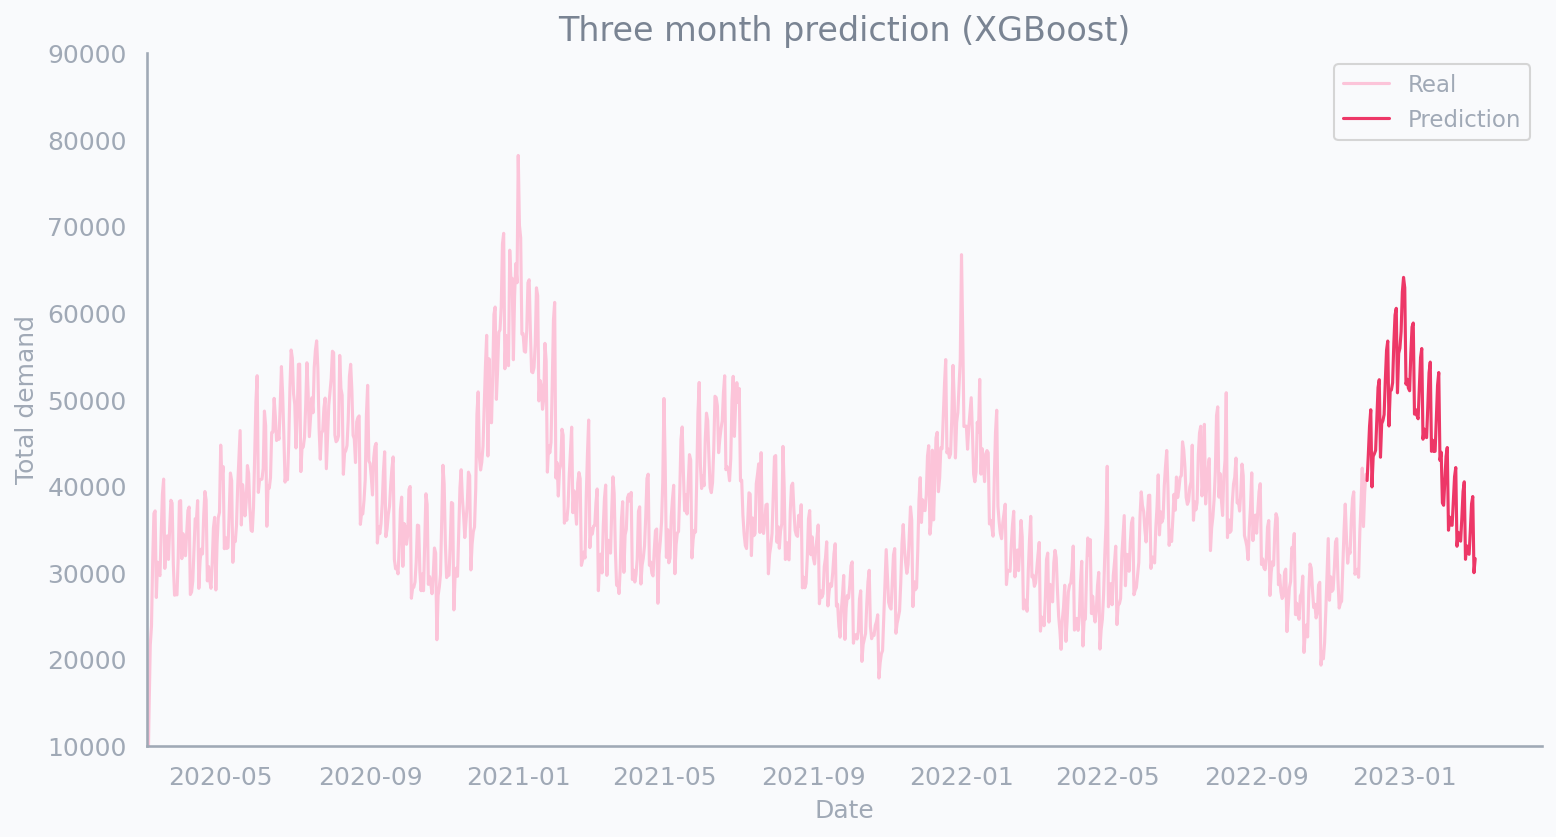

In [260]:
date_mask = test_set.date.isin(test_dates)

demand_pred_test = pd.DataFrame(
    data=test_set.loc[date_mask].demand.values,
    columns=['demand_pred'],
    index=pd.to_datetime(test_set.loc[date_mask].date)
)
demand_pred_test = demand_pred_test.resample('D').sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=demand_real, x="date", y="demand", color=pink, label='Real', alpha=0.5)
sns.lineplot(data=demand_pred_test, x="date", y="demand_pred", color=red, label='Prediction')
plt.title("Three month prediction (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Total demand")
plt.ylim(10_000, 90_000)
plt.xlim(pd.Timestamp('2020-03-01'))
plt.show()

Now we save our predictions

In [269]:
original_test = pd.read_csv("../data/processed/demand_products_test.csv")
print(original_test.shape)
original_test.head()

(11786, 8)


,date,product_id,category,subcategory,size,is_premium,is_exclusive,is_seasonal
0,2022-12-01,1,bebidas,agua,mediano,False,True,False
1,2022-12-01,2,jabones,antibacterial,pequeño,False,False,False
2,2022-12-01,3,bebidas,gaseosa,pequeño,False,True,False
3,2022-12-01,4,congelados,vegetales,pequeño,False,True,True
4,2022-12-01,5,shampoos,acondicionador,pequeño,False,True,False


In [270]:
original_test = original_test.sort_values(['product_id', 'date']) 
original_test['demand_prediction'] = test_set.loc[date_mask].demand.values
original_test.sort_index(inplace=True)

In [271]:
original_test

,date,product_id,category,subcategory,size,is_premium,is_exclusive,is_seasonal,demand_prediction
0,2022-12-01,1,bebidas,agua,mediano,False,True,False,64.888
1,2022-12-01,2,jabones,antibacterial,pequeño,False,False,False,366.121
2,2022-12-01,3,bebidas,gaseosa,pequeño,False,True,False,468.150
3,2022-12-01,4,congelados,vegetales,pequeño,False,True,True,204.058
4,2022-12-01,5,shampoos,acondicionador,pequeño,False,True,False,96.129
...,...,...,...,...,...,...,...,...,...
11781,2023-02-28,131,bebidas,vinos,pequeño,False,False,False,77.412
11782,2023-02-28,132,aseo,cuidado personal,pequeño,False,True,False,201.430
11783,2023-02-28,133,productos_enlatados_y_alimentos_envasados,indefinido,pequeño,False,False,False,91.194
11784,2023-02-28,134,productos_enlatados_y_alimentos_envasados,indefinido,pequeño,False,True,False,546.489


In [272]:
original_test.to_csv("../data/final/test.csv", index=False)